In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import gc  # Garbage collector


In [21]:
def initialize_accumulators():
    return {
        'total_images': 0,
        'patient_ids': set(),
        'label_counts': Counter(),
        'age_data': [],
        'invalid_age_count': 0,
        'gender_counts': Counter(),
        'image_widths': [],
        'image_heights': []
    }


In [22]:
def process_chunk(chunk, accumulators, min_age=0, max_age=100):
    # Update total images
    accumulators['total_images'] += chunk.shape[0]
    
    # Update patient IDs
    if 'Patient ID' in chunk.columns:
        accumulators['patient_ids'].update(chunk['Patient ID'].unique())
    
    # Process labels
    if 'Finding Labels' in chunk.columns:
        chunk['Labels List'] = chunk['Finding Labels'].str.split('|')
        chunk_labels = chunk.explode('Labels List')['Labels List']
        accumulators['label_counts'].update(chunk_labels.dropna())
    
    # Process age data
    if 'Patient Age' in chunk.columns:
        chunk['Patient Age'] = pd.to_numeric(chunk['Patient Age'], errors='coerce')
        valid_age_mask = (chunk['Patient Age'] >= min_age) & (chunk['Patient Age'] <= max_age)
        valid_ages = chunk.loc[valid_age_mask, 'Patient Age']
        accumulators['age_data'].extend(valid_ages.tolist())
        accumulators['invalid_age_count'] += chunk['Patient Age'].isna().sum() + (~valid_age_mask).sum()
    
    # Process gender data
    if 'Patient Gender' in chunk.columns:
        accumulators['gender_counts'].update(chunk['Patient Gender'].dropna())
    
    # Process image dimensions
    if 'OriginalImageWidth' in chunk.columns and 'OriginalImageHeight' in chunk.columns:
        chunk['OriginalImageWidth'] = pd.to_numeric(chunk['OriginalImageWidth'], errors='coerce')
        chunk['OriginalImageHeight'] = pd.to_numeric(chunk['OriginalImageHeight'], errors='coerce')
        accumulators['image_widths'].extend(chunk['OriginalImageWidth'].dropna().tolist())
        accumulators['image_heights'].extend(chunk['OriginalImageHeight'].dropna().tolist())


In [23]:
def aggregate_results(accumulators):
    num_patients = len(accumulators['patient_ids'])
    unique_labels = list(accumulators['label_counts'].keys())
    label_counts_df = pd.DataFrame.from_dict(accumulators['label_counts'], orient='index', columns=['Count'])
    label_counts_df = label_counts_df.sort_values('Count', ascending=False)
    return num_patients, unique_labels, label_counts_df


In [24]:
def plot_label_distribution(label_counts_df, dataset_name):
    plt.figure(figsize=(12,6))
    sns.barplot(x=label_counts_df.index, y='Count', data=label_counts_df)
    plt.title(f'{dataset_name} Class Distribution')
    plt.ylabel('Number of Images')
    plt.xlabel('Disease Labels')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [25]:
def plot_age_distribution(age_data, invalid_age_count, dataset_name):
    print("\n--- Age Analysis ---")
    print(f"Number of entries with invalid ages removed: {invalid_age_count}")
    if age_data:
        plt.figure(figsize=(8,5))
        sns.histplot(age_data, bins=30, kde=False)
        plt.title(f'{dataset_name} Age Distribution')
        plt.xlabel('Age (years)')
        plt.ylabel('Number of Patients')
        plt.show()
    else:
        print("No valid age data available.")


In [26]:
def plot_gender_distribution(gender_counts, dataset_name):
    if gender_counts:
        gender_counts_series = pd.Series(gender_counts)
        plt.figure(figsize=(6,6))
        plt.pie(gender_counts_series, labels=gender_counts_series.index, autopct='%1.1f%%', startangle=90)
        plt.title(f'{dataset_name} Gender Distribution')
        plt.ylabel('')
        plt.show()
    else:
        print("No gender data available.")


In [27]:
def plot_image_resolution_distribution(image_widths, image_heights, dataset_name):
    if image_widths and image_heights:
        image_sizes_df = pd.DataFrame({'Width': image_widths, 'Height': image_heights})
        print("Image size statistics:")
        display(image_sizes_df.describe())
        # Visualize image resolution distribution
        plt.figure(figsize=(8,5))
        sns.histplot(image_sizes_df['Width'], bins=20, color='blue', label='Width', kde=False)
        sns.histplot(image_sizes_df['Height'], bins=20, color='orange', label='Height', kde=False)
        plt.title(f'{dataset_name} Image Resolution Distribution')
        plt.xlabel('Pixels')
        plt.ylabel('Number of Images')
        plt.legend()
        plt.show()
        image_width_mean = image_sizes_df['Width'].mean()
        image_height_mean = image_sizes_df['Height'].mean()
    else:
        print("No image dimension data available.")
        image_width_mean = None
        image_height_mean = None
    return image_width_mean, image_height_mean


In [28]:
def plot_cumulative_label_distribution(label_counts_df, dataset_name):
    label_counts_df = label_counts_df.copy()
    label_counts_df['Cumulative Count'] = label_counts_df['Count'].cumsum()
    label_counts_df['Cumulative Percentage'] = 100 * label_counts_df['Cumulative Count'] / label_counts_df['Count'].sum()
    label_counts_df.reset_index(inplace=True)
    label_counts_df.rename(columns={'index': 'Label'}, inplace=True)
    
    plt.figure(figsize=(8,5))
    sns.lineplot(x=range(len(label_counts_df)), y='Cumulative Percentage', data=label_counts_df, label=dataset_name)
    plt.title(f'Cumulative Distribution of {dataset_name} Labels')
    plt.xlabel('Number of Labels')
    plt.ylabel('Cumulative Percentage')
    plt.show()
    
    # Return cumulative distribution data
    return label_counts_df[['Label', 'Cumulative Percentage']]


In [29]:
def analyze_dataset(file_path, dataset_name, column_names, chunksize=100000):
    print(f"\n--- Analyzing {dataset_name} Dataset ---")
    
    accumulators = initialize_accumulators()
    
    # Process the dataset in chunks
    for chunk in pd.read_csv(file_path, names=column_names, header=0, chunksize=chunksize):
        process_chunk(chunk, accumulators)
    
    num_patients, unique_labels, label_counts_df = aggregate_results(accumulators)
    
    # Display results
    print(f"Number of images: {accumulators['total_images']}")
    print(f"Number of unique patients: {num_patients}")
    print(f"Unique labels: {unique_labels}")
    print("\nLabel counts:")
    display(label_counts_df)
    
    # Plot distributions
    plot_label_distribution(label_counts_df, dataset_name)
    plot_age_distribution(accumulators['age_data'], accumulators['invalid_age_count'], dataset_name)
    plot_gender_distribution(accumulators['gender_counts'], dataset_name)
    print(f"\nAnalyzing image dimensions for {dataset_name} from metadata...")
    image_width_mean, image_height_mean = plot_image_resolution_distribution(
        accumulators['image_widths'], accumulators['image_heights'], dataset_name
    )
    # Collect cumulative distribution data
    cumulative_distribution_df = plot_cumulative_label_distribution(label_counts_df, dataset_name)
    
    # Return metrics
    metrics = {
        'Dataset': dataset_name,
        'Number of Images': accumulators['total_images'],
        'Number of Patients': num_patients,
        'Number of Classes': len(unique_labels),
        'Labels': unique_labels,
        'Label Counts': label_counts_df,
        'Image Width Mean': image_width_mean,
        'Image Height Mean': image_height_mean,
        'Cumulative Distribution': cumulative_distribution_df
    }
    return metrics


In [30]:
# Update these paths to where your datasets are stored
nih_column_names = [
    'Image Index',
    'Finding Labels',
    'Follow-up #',
    'Patient ID',
    'Patient Age',
    'Patient Gender',
    'View Position',
    'OriginalImageWidth',
    'OriginalImageHeight',
    'OriginalImagePixelSpacingX',
    'OriginalImagePixelSpacingY'
]
# NIH ChestX-ray14
nih_data_entry = './data/NIH/Data_Entry_2017.csv'
nih_images_dir = './data/NIH'  # Update to your images directory
nih_dataset_name = 'NIH ChestX-ray14'

# CheXpert
chexpert_metadata_path = 'path_to_CheXpert_data/train.csv'
chexpert_images_dir = 'path_to_CheXpert_data'  # Images are in subdirectories

# MIMIC-CXR
mimic_metadata_path = 'path_to_MIMIC_data/mimic-cxr-2.0.0-metadata.csv'
mimic_labels_path = 'path_to_MIMIC_data/labels.csv'  # Assuming labels are preprocessed
mimic_images_dir = 'path_to_MIMIC_images/files'  # Update to your images directory

# Parameters
csv_chunksize = 50000  # Adjust based on your system's memory
image_sample_size = 1000  # Number of images to sample for analysis



--- Analyzing NIH ChestX-ray14 Dataset ---


Number of images: 112120
Number of unique patients: 30805
Unique labels: ['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

Label counts:


,Count
No Finding,60361
Infiltration,19894
Effusion,13317
Atelectasis,11559
Nodule,6331
Mass,5782
Pneumothorax,5302
Consolidation,4667
Pleural_Thickening,3385
Cardiomegaly,2776


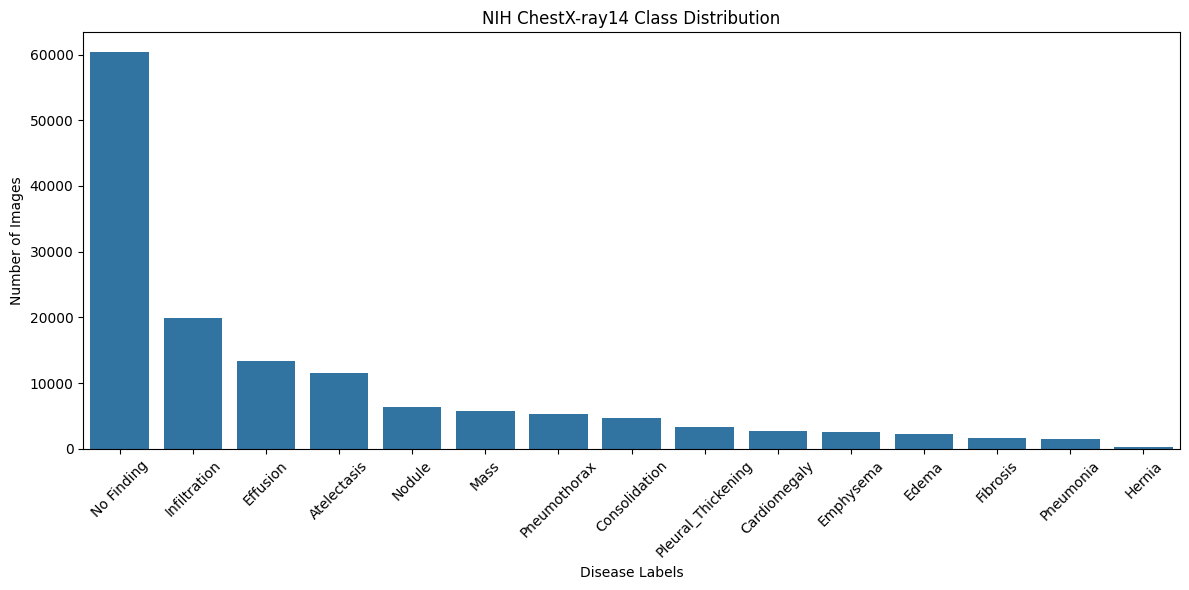


--- Age Analysis ---
Number of entries with invalid ages removed: 16


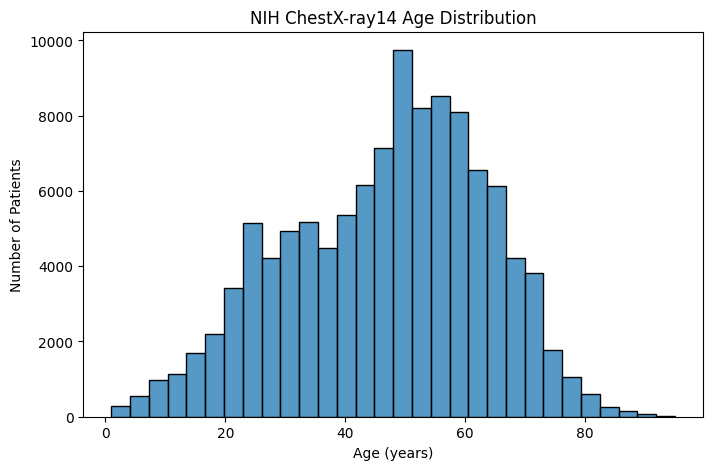

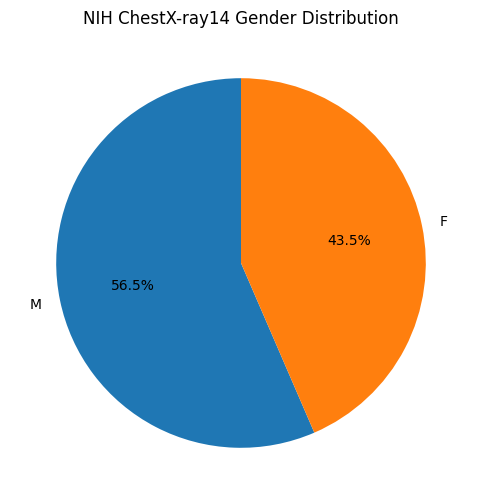


Analyzing image dimensions for NIH ChestX-ray14 from metadata...
Image size statistics:


,Width,Height
count,112120.000000,112120.000000
mean,2646.078844,2486.438842
std,341.246429,401.268227
min,1143.000000,966.000000
25%,2500.000000,2048.000000
50%,2518.000000,2544.000000
75%,2992.000000,2991.000000
max,3827.000000,4715.000000


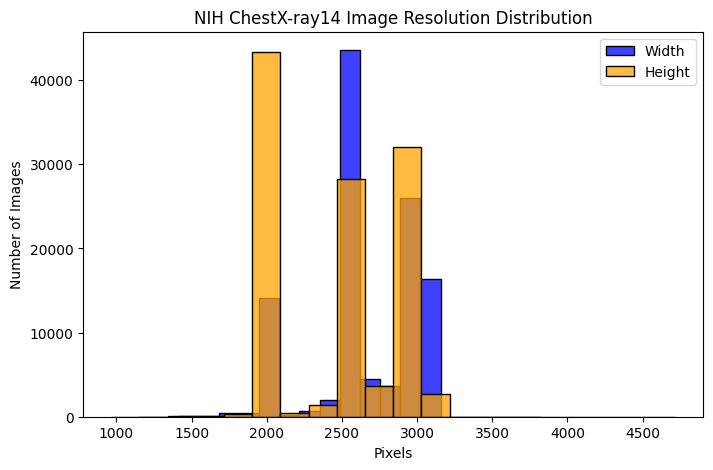

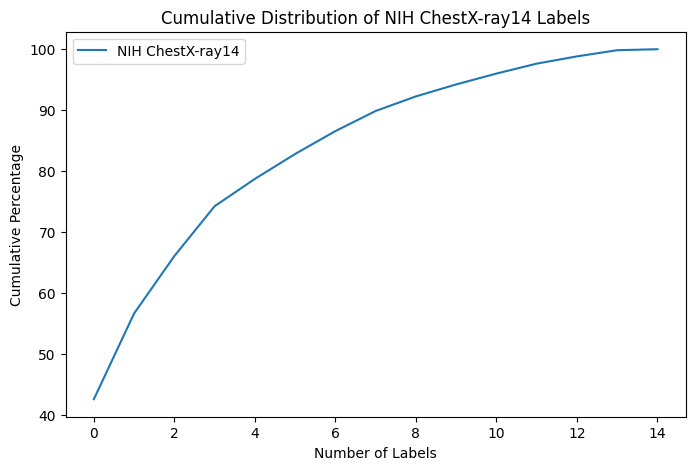

In [31]:
nih_metrics = analyze_dataset(nih_data_entry, nih_dataset_name, nih_column_names)

In [32]:
# chexpert_metrics = analyze_dataset(chexpert_file_path, chexpert_dataset_name, chexpert_column_names)

In [33]:
metrics_list = [nih_metrics]  # Add other dataset metrics to this list
# Example: metrics_list = [nih_metrics, chexpert_metrics]

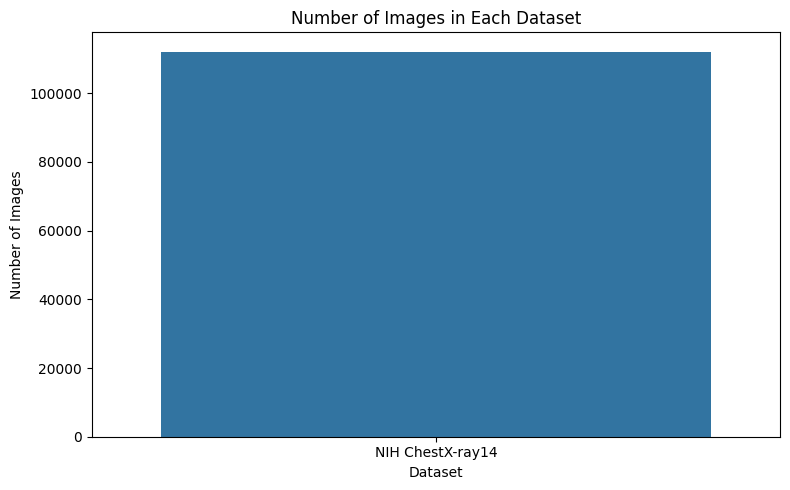

In [34]:
metrics_df = pd.DataFrame(metrics_list)
plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='Number of Images', data=metrics_df)
plt.title('Number of Images in Each Dataset')
plt.ylabel('Number of Images')
plt.xlabel('Dataset')
plt.tight_layout()
plt.show()

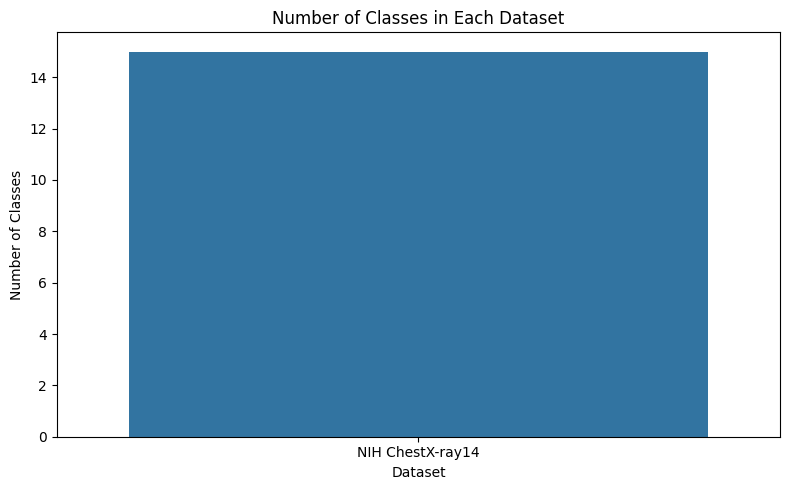

In [35]:
plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='Number of Classes', data=metrics_df)
plt.title('Number of Classes in Each Dataset')
plt.ylabel('Number of Classes')
plt.xlabel('Dataset')
plt.tight_layout()
plt.show()

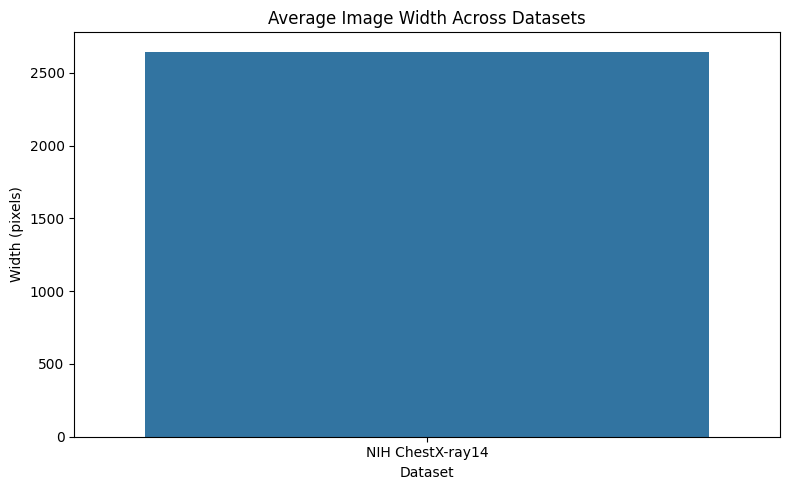

In [36]:
plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='Image Width Mean', data=metrics_df)
plt.title('Average Image Width Across Datasets')
plt.ylabel('Width (pixels)')
plt.xlabel('Dataset')
plt.tight_layout()
plt.show()


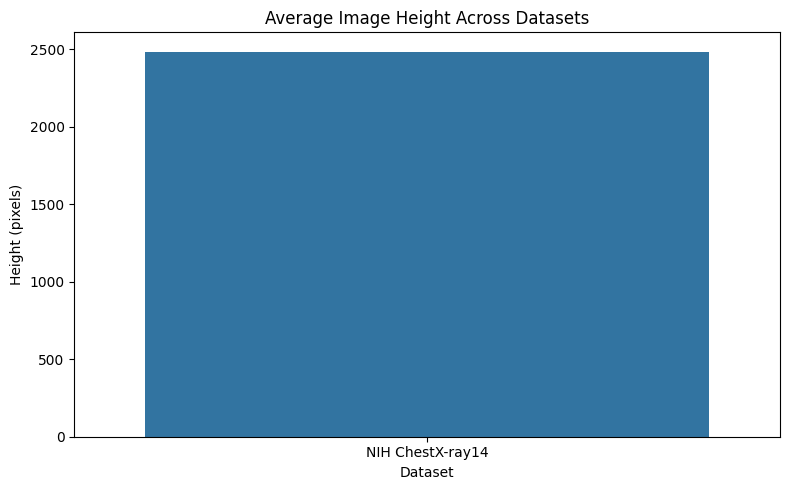

In [37]:
plt.figure(figsize=(8,5))
sns.barplot(x='Dataset', y='Image Height Mean', data=metrics_df)
plt.title('Average Image Height Across Datasets')
plt.ylabel('Height (pixels)')
plt.xlabel('Dataset')
plt.tight_layout()
plt.show()


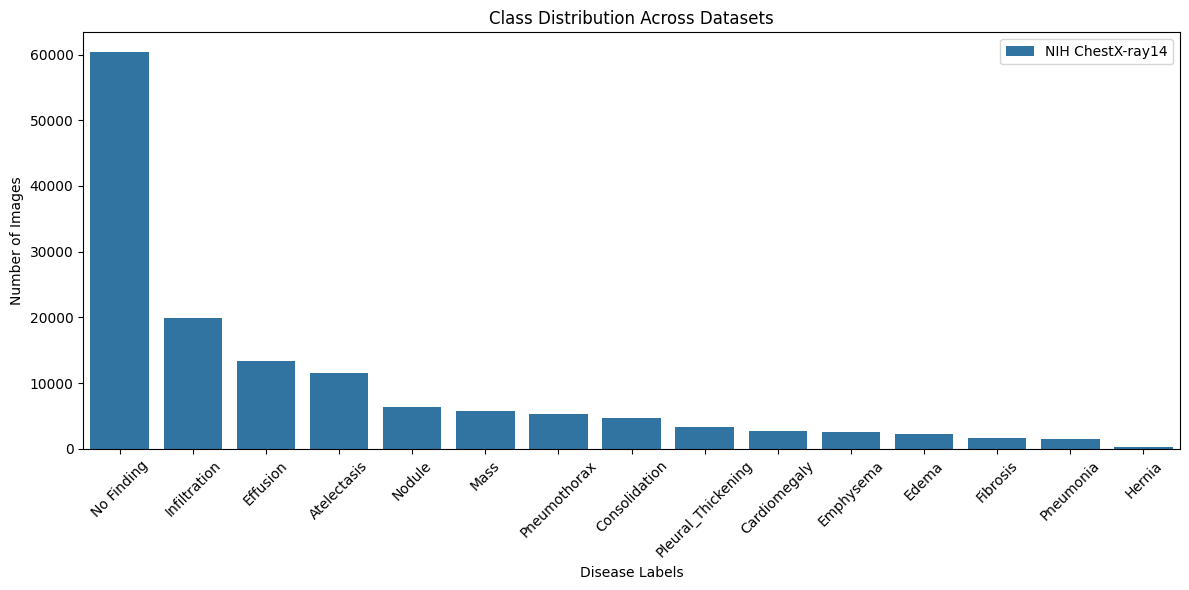

In [38]:
def prepare_label_counts_for_plot(metrics):
    df = metrics['Label Counts'].copy()
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Label'}, inplace=True)
    df['Dataset'] = metrics['Dataset']
    return df

# Prepare data for plotting
nih_label_counts_df = prepare_label_counts_for_plot(nih_metrics)

# Combine dataframes
combined_label_counts_df = pd.concat([nih_label_counts_df], ignore_index=True)
# Add other datasets to the combined dataframe as needed

# Plot combined class distribution
plt.figure(figsize=(12,6))
sns.barplot(x='Label', y='Count', hue='Dataset', data=combined_label_counts_df)
plt.title('Class Distribution Across Datasets')
plt.ylabel('Number of Images')
plt.xlabel('Disease Labels')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
# Prepare cumulative distribution data
def prepare_cumulative_data(metrics):
    df = metrics['Cumulative Distribution'].copy()
    df['Dataset'] = metrics['Dataset']
    df['Label Rank'] = range(1, len(df) + 1)  # Rank labels based on frequency
    return df

# Collect cumulative distribution data from each dataset
nih_cumulative_df = prepare_cumulative_data(nih_metrics)

# If you have more datasets, prepare their cumulative data
# chexpert_cumulative_df = prepare_cumulative_data(chexpert_metrics)
# mimic_cumulative_df = prepare_cumulative_data(mimic_metrics)

# Combine cumulative distribution data
combined_cumulative_df = pd.concat([nih_cumulative_df], ignore_index=True)
# Add other datasets to the combined dataframe as needed
# combined_cumulative_df = pd.concat([nih_cumulative_df, chexpert_cumulative_df, mimic_cumulative_df], ignore_index=True)


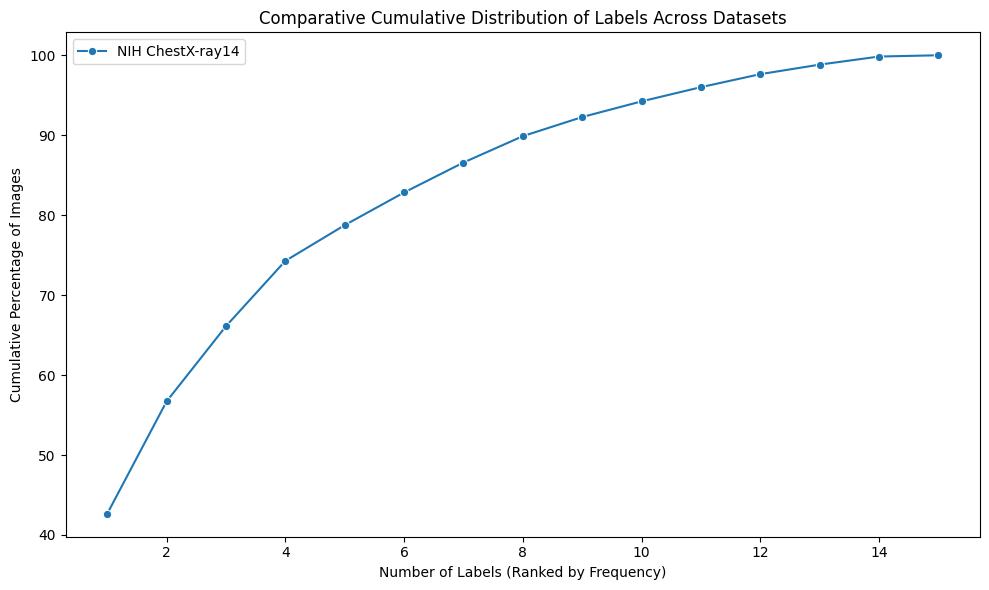

In [40]:
# Plot comparative cumulative distributions
plt.figure(figsize=(10,6))
sns.lineplot(
    data=combined_cumulative_df,
    x='Label Rank',
    y='Cumulative Percentage',
    hue='Dataset',
    marker='o'
)
plt.title('Comparative Cumulative Distribution of Labels Across Datasets')
plt.xlabel('Number of Labels (Ranked by Frequency)')
plt.ylabel('Cumulative Percentage of Images')
plt.legend()
plt.tight_layout()
plt.show()
